# Evaluate sensitivity for Hintereisferner and HistAlp

...

In [7]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
sys.path.append('../code/plots')
import plot_timeseries as plt_time

In [9]:
# define plot output directory
plot_dir = "/Users/oberrauch/work/master/plots/final_plots/sensitivity/"

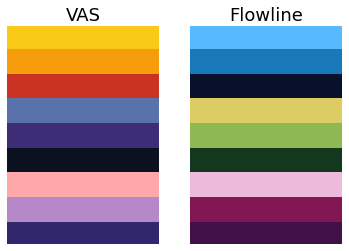

In [10]:
# get colors
sys.path.append('/Users/oberrauch/work/master/code/')
from master_colors import vas_cycle, fl_cycle, plot_colors
plot_colors([vas_cycle, fl_cycle], ['VAS', 'Flowline'])

## HEF Sensitivity

### Sensitivity to scaling parameters

In [45]:
# load scaling params sensitivity results
dir_path = '/Users/oberrauch/work/master/data/hef_sensitivity/'
f_name = 'scaling_param_sensitivity.nc'
ds = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))

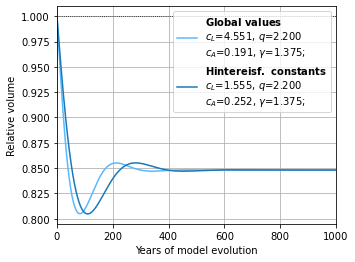

In [47]:
variables = ['volume']
n = True

for var in variables:
    # call plotting function
    titles = ['Global\ values', 'Hintereisf.\ constants', 'HISTALP\ const. &\  exp.']
    ds_plot = ds.sel(normalized=n, time_scale_factor=1)
    labels = [f'$\\bf{{{t}}}$\n$c_L$={c_l:.3f}, $q$={q:.3f}\n$c_A$={c_a:.3f}, $\gamma$={gamma:.3f};'
              for t, (c_l, c_a, q, gamma) in zip(titles, ds_plot.scaling_params.values)]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=fl_cycle, legend_loc=1,
                              path=os.path.join(plot_dir, 'scaling_params_hef.pdf'))

**Equilibrium values**

In [13]:
# get table with final values of volume for different time scales factors
var = 'area'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e6, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat([var], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

area                    
                                 abs                norm
scaling_params                                          
(1.555, 0.252, 2.2, 1.375)  7.128259  0.8870407197491634
(4.551, 0.191, 2.2, 1.375)  7.128236  0.8870378636562138

In [14]:
# get table with initial and final values as well as the difference between the two
var = 'volume'
dec_power = 1e9

data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_eq = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_init = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=0)[var]
        data.append([ds_init.values/dec_power, ds_eq.values/dec_power, ds_eq.values/dec_power - ds_init.values/dec_power])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat([var], 3),
                                                                np.tile(['init', 'eq', 'diff'], 1)))),)
table.sort_index()

volume                    
                                init        eq      diff
scaling_params                                          
(1.555, 0.252, 2.2, 1.375)  0.786739  0.667195 -0.119544
(4.551, 0.191, 2.2, 1.375)  0.596298  0.505689 -0.090609

**Time until equlibrium**

In [15]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=-1)[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
scaling_params,
"(1.555, 0.252, 2.2, 1.375)",493
"(4.551, 0.191, 2.2, 1.375)",371


**Maximum values**

In [16]:
# get table with final values of volume for different time scales factors
var = 'area'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs_min.values/1e6), 1-float(norm_min.values), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=['abs', 'norm', 'year'])
table.sort_index()

,abs,norm,year
scaling_params,,,
"(1.555, 0.252, 2.2, 1.375)",6.862396,0.146043,114
"(4.551, 0.191, 2.2, 1.375)",6.878157,0.144082,95


In [17]:
table['abs'].diff()

scaling_params
(4.551, 0.191, 2.2, 1.375)         NaN
(1.555, 0.252, 2.2, 1.375)   -0.015761
Name: abs, dtype: float64

In [18]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        abs_eq = ds_abs.isel(time=-1)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
"(1.555, 0.252, 2.2, 1.375)",0.034103,5.111387,110
"(4.551, 0.191, 2.2, 1.375)",0.025726,5.087306,82


**Response times $\tau$**

In [19]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(scaling_params=p, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.scaling_params.values, name='scaling_params'),
                   index=variables)
tau

scaling_params,"(4.551, 0.191, 2.2, 1.375)","(1.555, 0.252, 2.2, 1.375)"
volume,23,30
area,34,34
length,52,70


### Sensitivity to time scale

In [20]:
# load scaling params sensitivity results
dir_path = '/Users/oberrauch/work/master/data/hef_sensitivity/'
f_name = 'time_scale_sensitivity.nc'
ds = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))

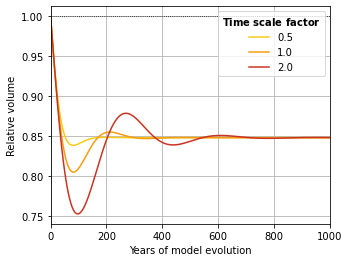

In [21]:
# define variable to be plotted
variables = ['length', 'area', 'volume']
variables = ['volume']
n = True

for var in variables:
    # call plotting function
    ds_plot = ds.sel(normalized=n).isel(scaling_params=0)
    ds_plot = ds_plot.sortby('time_scale_factor')
    labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=vas_cycle,
                              legend_title='$\\bf{Time\ scale\ factor}$', legend_loc=1,
                              path=os.path.join(plot_dir, 'time_scales_hef.pdf'))

**Equilibrium values**

In [22]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

volume                    
                        abs                norm
time_scale_factor                              
0.5                0.505689  0.8480479145549036
1.0                0.505689  0.8480480833923567
2.0                0.505783  0.8482050985612222

In [23]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=slice(800,1000))[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
time_scale_factor,
0.5,150
1.0,371
2.0,688


<AxesSubplot:xlabel='time_scale_factor'>

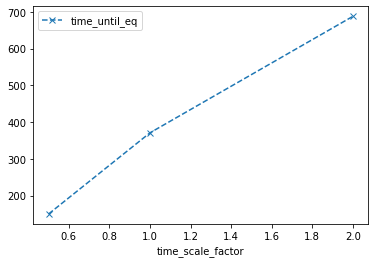

In [24]:
table.sort_index().plot(ls='--', marker='x')

**Maximum values**

In [25]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        abs_eq = ds_abs.isel(time=-1)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
0.5,0.005761,1.139278,81
1.0,0.025726,5.087306,82
2.0,0.056987,11.267106,97


**Response times $\tau$**

In [26]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(time_scale_factor=f, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                   index=variables)
tau.sort_index(axis=1)

time_scale_factor,0.5,1.0,2.0
volume,24,23,22
area,30,34,41
length,42,52,67


## HISTALP Sensitivity

### Sensitivity to scaling parameters

In [49]:
# load scaling params sensitivity results
path = '/Users/oberrauch/work/master/data/cluster_output/scaling_params/run_output_constant_vas.nc'
ds = pickle.load(open(path, mode='rb'))

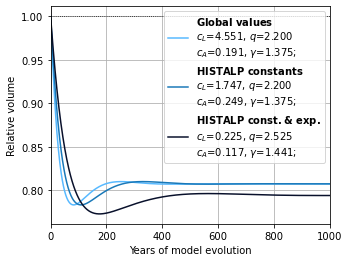

In [50]:
variables = ['volume']
path = os.path.join(plot_dir, 'scaling_params_histalp.pdf')

for var in variables:
    # call plotting function
    titles = ['Global\ values', 'HISTALP\ constants', 'HISTALP\ const. &\  exp.']
    ds_plot = ds.sel(normalized=True, time_scale_factor=1)
    labels = [f'$\\bf{{{t}}}$\n$c_L$={c_l:.3f}, $q$={q:.3f}\n$c_A$={c_a:.3f}, $\gamma$={gamma:.3f};'
              for t, (c_l, c_a, q, gamma) in zip(titles, ds_plot.scaling_params.values)]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=fl_cycle[:3],
                              legend_loc=1,
                              path=path)

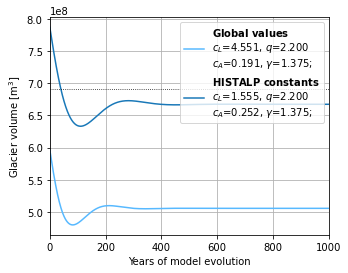

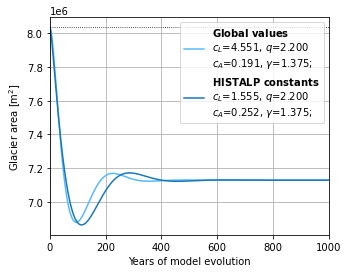

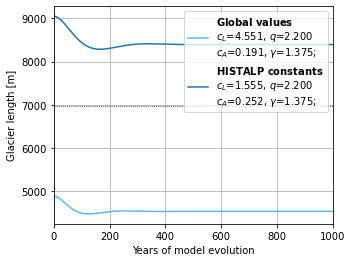

In [48]:
variables = ['volume', 'area', 'length']
path = False

for var in variables:
    # call plotting function
    titles = ['Global\ values', 'HISTALP\ constants', 'HISTALP\ const. &\  exp.']
    ds_plot = ds.sel(normalized=False, time_scale_factor=1)
    labels = [f'$\\bf{{{t}}}$\n$c_L$={c_l:.3f}, $q$={q:.3f}\n$c_A$={c_a:.3f}, $\gamma$={gamma:.3f};'
              for t, (c_l, c_a, q, gamma) in zip(titles, ds_plot.scaling_params.values)]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels, color_cycle=fl_cycle[:3],
                              legend_loc=1, path=path)

**Equilibrium values**

In [30]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table

volume                    
                                     abs                norm
scaling_params                                              
(4.551, 0.191, 2.2, 1.375)    105.359539    0.80744089621456
(1.747, 0.249, 2.2, 1.375)    137.350549  0.8074233395615318
(0.225, 0.117, 2.525, 1.441)  182.412935   0.794038781992696

In [31]:
# get table with initial and final values as well as the difference between the two
var = 'volume'
n = False
dec_power = 1e9


data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_eq = ds.sel(scaling_params=p, normalized=n).squeeze().isel(time=1000)[var]
        ds_init = ds.sel(scaling_params=p, normalized=n).squeeze().isel(time=0)[var]
        data.append([ds_init.values/dec_power, ds_eq.values/dec_power, ds_eq.values/dec_power - ds_init.values/dec_power])
        
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='scaling_params'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat([var], 3),
                                                                np.tile(['init', 'eq', 'diff'], 1)))),)
table

volume                       
                                    init          eq       diff
scaling_params                                                 
(4.551, 0.191, 2.2, 1.375)    130.485760  105.359539 -25.126221
(1.747, 0.249, 2.2, 1.375)    170.109709  137.350549 -32.759160
(0.225, 0.117, 2.525, 1.441)  229.727992  182.412935 -47.315057

**Maximum values**

In [32]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(scaling_params=p, normalized=False).squeeze()[var]
        ds_norm = ds.sel(scaling_params=p, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        abs_eq = ds_abs.isel(time=-1)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
    
table = pd.DataFrame(data, index=pd.Index(ds.scaling_params.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
"(0.225, 0.117, 2.525, 1.441)",4.858937,2.663702,175
"(1.747, 0.249, 2.2, 1.375)",4.111627,2.993528,109
"(4.551, 0.191, 2.2, 1.375)",3.156362,2.995800,83


**Response times $\tau$**

In [33]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for p in ds.scaling_params:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(scaling_params=p, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.scaling_params.values, name='scaling_params'),
                   index=variables)
tau

scaling_params,"(4.551, 0.191, 2.2, 1.375)","(1.747, 0.249, 2.2, 1.375)","(0.225, 0.117, 2.525, 1.441)"
volume,20,27,41
area,27,29,40
length,30,42,48


### Sensitivity to time scale

In [34]:
# load time scale sensitivity results
path = '/Users/oberrauch/work/master/data/cluster_output/timescale_sensitivity/run_output_constant_vas.nc'
ds = pickle.load(open(path, mode='rb'))

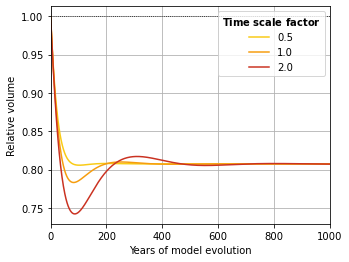

In [35]:
# call plotting function
ds_plot = ds.sel(normalized=True).isel(scaling_params=0)
ds_plot = ds_plot.sortby('time_scale_factor')
labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
plt_time.plot_time_series(ds_plot, var='volume', labels=labels, color_cycle=vas_cycle[:3],
                          legend_title='$\\bf{Time\ scale\ factor}$', legend_loc=1,
                          path=os.path.join(plot_dir, 'time_scales_histalp.pdf'))

**Equilibrium values**

In [36]:
# get table with final values of volume for different time scales factors
var = 'volume'
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=1000)[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze().isel(time=1000)[var]
        data.append([ds_abs.values/1e9, ds_norm.values])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table.sort_index()

volume                    
                          abs                norm
time_scale_factor                                
0.5                105.359270  0.8074388316639997
1.0                105.359539    0.80744089621456
2.0                105.336012  0.8072605885871897

In [37]:
# get table with final values of volume for different time scales factors
var = 'volume'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        geom = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        geom_eq_value = ds.sel(time_scale_factor=f, normalized=False).squeeze().isel(time=-1)[var].mean().values
        geom_limit = geom_eq_value * 0.001
        geom_eq = geom.where(abs(geom - geom_eq_value) < geom_limit)
        yr = geom_eq.where(xr.ufuncs.isnan(geom_eq), drop=True).isel(time=-1).time.values+1
        data.append(int(yr))

table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'), columns=['time_until_eq'])
table.sort_index()    

,time_until_eq
time_scale_factor,
0.5,133
1.0,335
2.0,642


**Maximum values**

In [38]:
# get table with final values of volume for different time scales factors
var = 'volume'
dec_power = 1e9
mb_m = 'constant'
data = list()

for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(time_scale_factor=f, normalized=False).squeeze()[var]
        ds_norm = ds.sel(time_scale_factor=f, normalized=True).squeeze()[var]
        abs_min = ds_abs.where(ds_abs == ds_abs.min(), drop=True)
        abs_eq = ds_abs.isel(time=-1)
        norm_min = ds_norm.where(ds_abs == ds_abs.min(), drop=True)
        data.append([float(abs(abs_min.values-abs_eq.values))/dec_power, float(abs(abs_min.values-abs_eq.values)/abs_eq.values*100), int(norm_min.time.values)])
        
table = pd.DataFrame(data, index=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                     columns=['abs', 'rel. overshoot', 'year'])
table.sort_index()

,abs,rel. overshoot,year
time_scale_factor,,,
0.5,0.211398,0.200645,103
1.0,3.156362,2.995800,83
2.0,8.476486,8.047092,87


**Response times $\tau$**

In [39]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for f in ds.time_scale_factor:
        # select last volume entry from dataset by model and temperature bias
        ds_sel = ds.sel(time_scale_factor=f, normalized=False).squeeze()
        geom = ds_sel[var]
        geom_eq = geom.isel(time=slice(800,1000)).mean()
        geom_eq_dif = np.abs(geom_eq - geom.isel(time=0))
        geom_dif = np.abs(geom_eq - geom)
        data_.append(int(geom.where(geom_dif < geom_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.Index(ds.time_scale_factor.values, name='time_scale_factor'),
                   index=variables)
tau

time_scale_factor,1.0,0.5,2.0
volume,20,23,19
area,27,26,31
length,30,29,32


## Test

### Sensitivity to time scale

In [40]:
dir_path = '/Users/oberrauch/work/master/data/'
# load time scale sensitivity results
f_name = 'timescale_sensitivity/run_output_constant_vas.nc'
ds_ts = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))
# load scaling params sensitivity results
f_name = 'scaling_params/run_output_constant_vas.nc'
ds_sc = pickle.load(open(os.path.join(dir_path, f_name), mode='rb'))

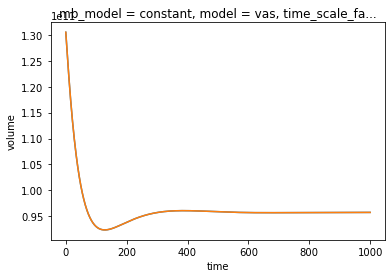

In [41]:
ds_sc.sel(scaling_params=ds_ts.scaling_params, normalized=False).volume.plot()
ds_ts.sel(time_scale_factor=ds_sc.time_scale_factor, normalized=False).volume.plot()

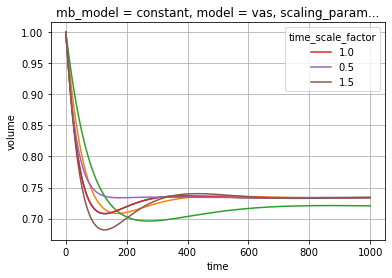

In [42]:
ds_sc.sel(normalized=True).squeeze().volume.plot.line(x='time')
ds_ts.sel(normalized=True).squeeze().volume.plot.line(x='time')
plt.grid()

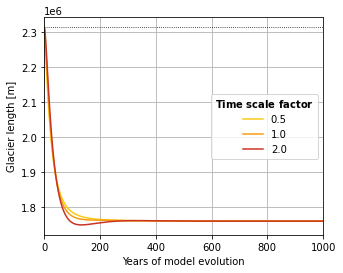

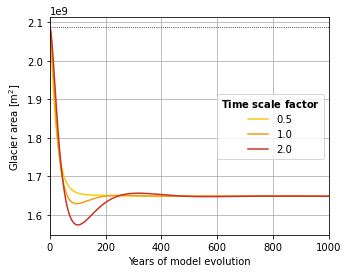

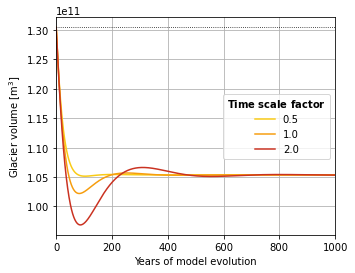

In [43]:
# define variable to be plotted
variables = ['length', 'area', 'volume']
n = False

for var in variables:
    # call plotting function
    ds_plot = ds.sel(normalized=n).isel(scaling_params=0)
    ds_plot = ds_plot.sortby('time_scale_factor')
    labels = [f'{f:.1f}' for f in ds_plot.time_scale_factor.values]
    plt_time.plot_time_series(ds_plot, var=var, labels=labels,
                              color_cycle=vas_cycle, legend_title='$\\bf{Time\ scale\ factor}$')

In [44]:
time_scale_factor

NameError: name 'time_scale_factor' is not defined